## Lab 11: The Age of the Universe

Sometimes, the primary purpose of regression analysis is to learn something about the slope or intercept of the best-fitting line.  When we use a sample of data to estimate the slope or intercept, our estimate is subject to random error, just as in the simpler case of the mean of a random sample.

In this lab, we'll use regression to get an accurate estimate for the age of the universe, using pictures of exploding stars.  Our estimate will come from a sample of all exploding stars. We'll compute a confidence interval to quantify the error caused by sampling.

In [2]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [3]:
# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('lab11.ok')
try:
    _ = ok.auth(inline=True)
except:
    _ = ok.auth(inline=True, force=True)

Assignment: Lab 11: The Age of the Universe
OK, version v1.14.15



ERROR  | auth.py:102 | {'error': 'invalid_grant'}



Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: 5GUMLACLvJuk85EaUW8D2D2w4n0JIV
Successfully logged in as togden1@binghamton.edu


### The Actual Big Bang Theory
In the early 20th century, the most popular cosmological theory suggested that the universe had always existed at a fixed size.  Today, the Big Bang theory prevails: Our universe started out very small and is still expanding.

A consequence of this is Hubble's Law, which states that every celestial object that's reasonably far away from Earth (for example, another galaxy) is moving away from us at a constant speed.  If we extrapolate that motion backwards to the time when everything in the universe was concentrated on a single point, then that time is (roughly) the beginning of the universe!

Scientists have used this idea, along with measurements of the current *location* and *movement speed* of other celestial objects, to estimate when the universe started.

The cell below simulates a universe in which our sun is the center and every other star is moving away from us.  Each star starts at the same place as the sun, then moves away from it over time.  Different stars have different directions *and speeds*; the arrows indicate the direction and speed of travel.

Run the cell, then move the slider to see how things change over time.

In [4]:
# Just run this cell.  (The simulation is actually not
# that complicated; it just takes a lot of code to draw
# everything.  So you don't need to read this unless you
# have time and are curious about more advanced plotting.)

num_locations = 15
example_velocities = Table().with_columns(
    "x", np.random.normal(size=num_locations),
    "y", np.random.normal(size=num_locations))
start_of_time = -2

def scatter_after_time(t, start_of_time, end_of_time, velocities, center_name, other_point_name, make_title):
    max_location = 1.1*(end_of_time-start_of_time)*max(max(abs(velocities.column("x"))), max(abs(velocities.column("y"))))
    new_locations = velocities.with_columns(
            "x", (t-start_of_time)*velocities.column("x"),
            "y", (t-start_of_time)*velocities.column("y"))
    plt.scatter(make_array(0), make_array(0), label=center_name, s=100, c="yellow")
    plt.scatter(new_locations.column("x"), new_locations.column("y"), label=other_point_name)
    for i in np.arange(new_locations.num_rows):
        plt.arrow(
            new_locations.column("x").item(i),
            new_locations.column("y").item(i),
            velocities.column("x").item(i),
            velocities.column("y").item(i),
            fc='black',
            ec='black',
            head_width=0.025*max_location,
            lw=.15)
    plt.xlim(-max_location, max_location)
    plt.ylim(-max_location, max_location)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_position(make_array(0, 0, 1, 1))
    plt.legend(bbox_to_anchor=(1.6, .7))
    plt.title(make_title(t))
    plt.show()

interact(
    scatter_after_time,
    t=widgets.FloatSlider(min=start_of_time, max=5, step=.05, value=0, msg_throttle=1),
    start_of_time=fixed(start_of_time),
    end_of_time=fixed(5),
    velocities=fixed(example_velocities),
    center_name=fixed("our sun"),
    other_point_name=fixed("other star"),
    make_title=fixed(lambda t: "The world {:01g} year{} in the {}".format(abs(t), "" if abs(t) == 1 else "s", "past" if t < 0 else "future")));

A Jupyter Widget

#### Question 1
From the example above, when can you say the simulated universe started? (You could either investigate the source code or play with the widget above to find the answer).

-2 years ago

#### Question 2
After 5 years in the simulation, stars with longer arrows are further away from the Sun. Why?

**Note:** 5 years corresponds to the slider being placed all the way to the right.

A longer arrow means a higher velocity.+

### A driving analogy

Here's an analogy to illustrate how scientists use information about stars to estimate the age of the universe.

Suppose that at some point in the past, our friend Mei started driving in a car going at a steady speed of 60 miles per hour straight east.  We're still standing where she started.

In [5]:
# Run this cell to see a picture of Mei's locations over time.

mei_velocity = Table().with_columns("x", make_array(60), "y", make_array(0))
interact(
    scatter_after_time,
    t=widgets.FloatSlider(min=-2, max=1, step=.05, value=0, msg_throttle=1),
    start_of_time=fixed(-2),
    end_of_time=fixed(1),
    velocities=fixed(mei_velocity),
    center_name=fixed("Us"),
    other_point_name=fixed("Mei"),
    make_title=fixed(lambda t: "Mei's position {:01g} hour{} in the {}".format(abs(t), "" if abs(t) == 1 else "s", "past" if t < 0 else "future")));

A Jupyter Widget

We want to know how long she's been driving, but we forgot to record the time when she left.  If we find out that she's 120 miles away, and she's been going 60 miles per hour the whole time, we can infer that she left 2 hours ago.

One way we can compute that number is by fitting a line to a scatter plot of our locations and speeds.  It turns out that the *slope* of that line is the amount of time that has passed.  Run the next cell to see a picture:

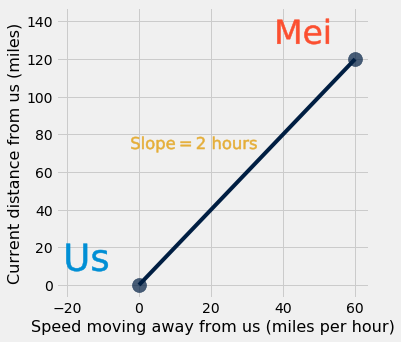

In [6]:
# Just run this cell.
small_driving_example = Table().with_columns(
        "Name",                                       make_array("Us", "Mei"),
        "Speed moving away from us (miles per hour)", make_array(0,    60),
        "Current distance from us (miles)",           make_array(0,    120))

small_driving_example.scatter(1, 2, s=200, fit_line=True)

# Fancy magic to draw each person's name with their dot.
with_slope_indicator = small_driving_example.with_row(
    ["Slope = 2\ hours", small_driving_example.column(1).mean(), small_driving_example.column(2).mean()])
for i in range(with_slope_indicator.num_rows):
    name = with_slope_indicator.column(0).item(i)
    x = with_slope_indicator.column(1).item(i)
    y = with_slope_indicator.column(2).item(i)
    plt.scatter(make_array(x - 15), make_array(y + 15), s=1000*len(name), marker="$\mathrm{" + name + "}$")

There are only two points in the scatter plot. The left point is (0,0). The right point is (distance, speed). The slope of the line is 2 hours.  (The units are vertical-axis units divided by horizontal-axis units, which are $\frac{\texttt{miles}}{\texttt{miles} / \texttt{hour}}$, or hours.)  So that's our answer. Note that this is a overly simplified linear regression model, with only two points in the scatter. We normally would not use linear regression model in this way. However, the next paragraph will explain why this approach may be applied to the problem of estimating the age of the universe.

Imagine that you don't know Mei's exact distance or speed, only rough estimates.  Then if you drew this line, you'd get a slightly bad estimate of the time since she left. Bad as overestimate or underestimate (we would not be able to know which).  But suppose now that there are hundreds of people like Mei. If you measured the distance and speed of hundreds of people who left you at the same time going different speeds, and drew a line through them, the slope of that line would be a pretty good estimate of the time they left, even if the individual measurements weren't exactly right. This is because individually this slope estimate may overestimate for some people and underestimate for some other people. But when you pool all these people together and come up with a single slope estimate, the positive and negative effects somewhat cancel out.  

The `drivers.csv` dataset contains the speeds and distances-from-start of 100 drivers.  They all left the same starting location at the same time, driving at a fixed speed on a straight line away from the start.  The measurements aren't exact, so they don't fit exactly on a line.  We've created a scatter plot and drawn a line through the data. We have added the data point (0,0) to the data since the fitted line is supposed to go through that point. But even if we did not add (0,0), the fitted line would still stay roughly the same.

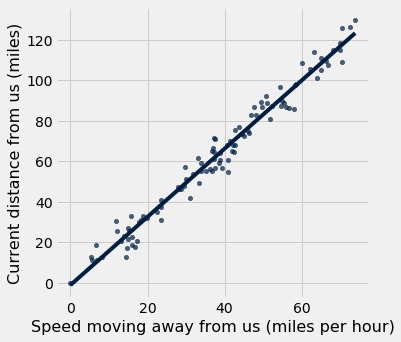

In [7]:
# Just run this cell.
Table.read_table("drivers.csv").with_row([0,0]).scatter(0, 1, fit_line=True)

#### Question 3
By looking at the fit line, estimate how long ago (in hours) Mei (or any of these 100 drivers) left. You do not have to code anything, just look at the plot and estimate a value. A rough estimate would be sufficient (as long as the test below passes). 

In [8]:
# Fill in the start time you infer from the above line.
driving_start_time_hours = 100/60
driving_start_time_hours

1.6666666666666667

In [9]:
_ = ok.grade('q3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Back to cosmology
To do the same thing for the universe, we need to know the distance-from-Earth and speed-away-from-Earth of many celestial objects.  Using pictures taken by very accurate telescopes and a lot of physics, astronomers have been able to estimate both.  It turns out that *nearby supernovae* -- stars that have recently died and exploded -- are among the best sources of this data, because they are very easy to see.  This picture taken by the Hubble telescope shows an entire galaxy, with a single supernova - as bright by itself as billions of stars - at the bottom left.

<img src="supernova.jpg">

Our astronomical data for today will come from the [Supernova Cosmology Project](http://supernova.lbl.gov/union/) at Lawrence Berkeley Lab.  The original dataset is [here](http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt), with (brief) documentation [here](http://supernova.lbl.gov/union/descriptions.html#Magvsz).  Each row in the table corresponds to a supernova near Earth that was observed by astronomers.  From pictures like the one above, the astronomers deduced how far away each supernova was from Earth and how fast it was moving away from Earth.  Their deductions were good, but not perfect.

Run the cell below to load the data into a table called `close_novas` and make a scatter plot. (If you prefer, you can also use the name `close_novae`; both are correct.)

Speed (parsecs/year) | Distance (million parsecs)
0.00873361           | 117.305
0.0153418            | 217.007
0.0162256            | 230.961
0.00528131           | 85.2853
0.0129474            | 185.051
0.0138862            | 212.841
0.0111837            | 151.728
0.0060085            | 82.6121
0.00838228           | 104.029
0.00812078           | 124.778
... (146 rows omitted)

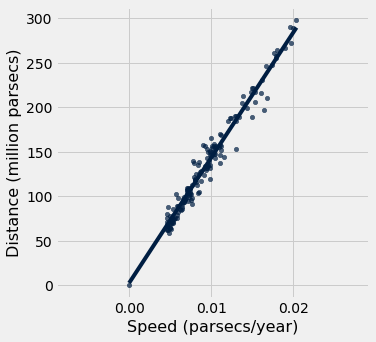

In [10]:
# Just run this cell.
close_novas = Table.read_table("close_novas.csv")
close_novae = close_novas

close_novas.with_row([0,0]).scatter(0, 1, fit_line=True)
close_novas

#### Question 4
Looking this plot, make a guess at the age of the universe.

**Note**: Make sure you get the units right!  In case you need to know what a parsec is, it's a big unit of distance, equivalent to 30.86 trillion kilometers. Again, you do not neccessarily need to code anything. Although you may use a calculator. Do not miss a zero.

In [11]:
# Fill this in manually by examining the line above.
first_guess_universe_age_years = 150e6/.01

# This just shows your guess as a nice string, in billions of years.
"{:,} billion years".format(round(first_guess_universe_age_years / 1e9, 2))

'15.0 billion years'

In [12]:
_ = ok.grade('q4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Fitting the line yourself
`fit_line=True` is convenient, but we need to be able to calculate the slope as a number.  Recall that the least-squares regression line for our supernova data is:
* the line
* with the smallest average (over all the supernovae we observe)
* error,
* squared,
* where the error is

$$\text{the supernova's actual distance from Earth} - \text{the height of the line at that supernova's speed.}$$

#### Question 5
Define a function called `errors`.  It should take three arguments:
1. a table like `close_novas` (with the same column names and meanings, but not necessarily the same data)
2. the slope of a line (an arbitary number)
3. the intercept of a line (an arbitary number).

It should return an array of the errors (or residuals) made when a line with that slope and intercept is used to predict distance from speed for each supernova in the given table.  (The error is the actual distance minus the predicted distance.)

In [13]:
def errors(tbl, slope, intercept):
    y_hat = [slope*x + intercept for x in tbl['Speed (parsecs/year)']]
    return [(s-t) for s,t in zip(tbl['Distance (million parsecs)'], y_hat)]

#### Question 6
Using `errors`, compute the errors for the line with slope `16000` and intercept `0` on the `close_novas` dataset. Name that array `example_errors`.  Then make a scatter plot of the errors.

From now on, we are not going to add an addition row of (0,0) (i.e. do not use `.with_row([0,0])`). Just use the original `close_novas` dataset.

**Hint:** To make a scatter plot of the errors, plot the error for each supernova in the dataset.  Put the actual speed for each supernova on the horizontal axis and the error on the vertical axis.

1


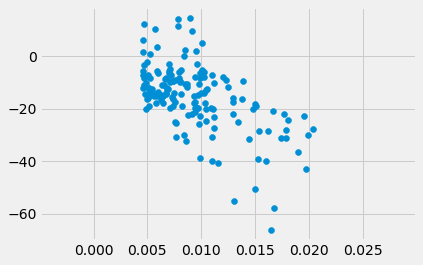

In [14]:
example_errors = make_array(errors(close_novas, 16000, 0))
print(len(example_errors))
plt.scatter(close_novas['Speed (parsecs/year)'], example_errors)

In [15]:
_ = ok.grade('q6')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



You should find that the errors are almost all negative.  That means our line is a little bit too steep.  Let's find a better one.

#### Question 7
Define a function called `fit_line`.  It should take a table like `close_novas` (with the same column names and meanings) as its argument.  It should return an array containing the slope (as item 0) and intercept (as item 1) of the least-squares regression line predicting distance from speed for that table. In this function, it should define the `mse` function which takes a possible slope value and a possible intercept value as two arguments, and return the mean square error of the regression line givin these arguments. Then you may want to use the `minimize` function to find the solution.

Note: If you haven't tried to use the `minimize` [function](http://data8.org/datascience/util.html#datascience.util.minimize) yet, now is a great time to practice. Here's an [example from the textbook](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html#numerical-optimization).

In [16]:
def fit_line(tbl):
    # Your code may need more than 1 line below here.
    def mse(slope, intercept):
        y_hat = [slope*x + intercept for x in tbl['Speed (parsecs/year)']]
        return sum([(s-t)**2 for s,t in zip(tbl['Distance (million parsecs)'], y_hat)])
    best_slope, best_intercept = minimize(mse)
    # You may want to use minimize here to find the solutions to minize the mse function.
    return best_slope, best_intercept
    
# Here is an example call to your function.  To test your function,
# figure out the right slope and intercept by hand.
example_table = Table().with_columns(
    "Speed (parsecs/year)", make_array(0, 1),
    "Distance (million parsecs)", make_array(1, 3))
fit_line(example_table)

(2.000000000000001, 1.0)

In [17]:
_ = ok.grade('q7')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 8
Use your function to fit a line to `close_novas`.

Then, set `new_errors` equal to the errors that we get by calling `errors` for our new line. The following cell will graph the corresponding residual plot with a best fit line.

Make sure that the residual plot makes sense (Hint: what qualities should the residual plot have?)

'Slope: 14094.5 (corresponding to an estimated age of 14.0945 billion years)'

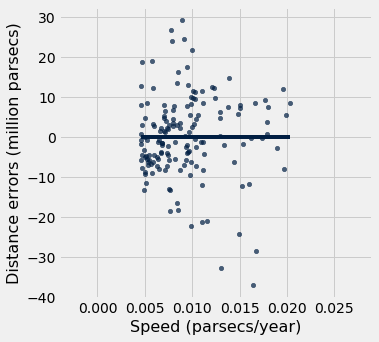

In [18]:
best_line = fit_line(close_novas)
best_line_slope = best_line[0]
best_line_intercept = best_line[1]

new_errors = errors(close_novas, best_line_slope, best_line_intercept)

# This code displays the residual plot, given your values for the best_line_slope and best_line_intercept
Table().with_columns("Speed (parsecs/year)", 
                    close_novas["Speed (parsecs/year)"], 
                    "Distance errors (million parsecs)", 
                    new_errors).scatter(0, 1, fit_line=True)

# This just shows your answer as a nice string, in billions of years.
"Slope: {:g} (corresponding to an estimated age of {:,} billion years)".format(best_line_slope, round(best_line_slope/1000, 4))

That slope (multiplied by 1 million) is an estimate of the age of the universe.  The current best estimate of the age of the universe (using slightly more sophisticated techniques) is 13.799 billion years.  Did we get close?

One reason our answer might be a little off is that we are using a sample of only some of the supernovae in the universe.  Our sample isn't exactly random, since astronomers presumably chose the novae that were easiest to measure (or used some other nonrandom criteria).  But let's assume it is.  How can we produce a confidence interval for the age of the universe?

#### Question 9
It's time to bootstrap so that we can quantify the variability in our estimate! Simulate 1000 resamples from `close_novas` (each resample has the same sample size as the original sample).  For each resample, compute the slope of the least-squares regression line, and multiply it by 1 million to compute an estimate of the age of the universe.  Store these ages in an array called `bootstrap_ages`, and then use them to compute a 95% confidence interval for the age of the universe.

**Note:** This might take up to a minute, and more repetitions will take even longer.

95% confidence interval for the age of the universe: [12.7532, 15.5138] billion years


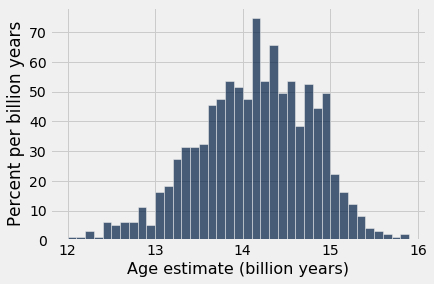

In [19]:
bootstrap_ages = []
for i in np.arange(1000):
    bootstrap_ages.append(fit_line(close_novas.sample(k=20))[0]*1e6)

lower_end = np.mean(bootstrap_ages) - 2*np.std(bootstrap_ages)
upper_end = np.mean(bootstrap_ages) + 2*np.std(bootstrap_ages)
Table().with_column("Age estimate", np.multiply(bootstrap_ages,1e-9)).hist(bins=np.arange(12, 16, .1), unit="billion years")
print("95% confidence interval for the age of the universe: [{:g}, {:g}] billion years".format(lower_end*1e-9, upper_end*1e-9))

In [20]:
_ = ok.grade('q9')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Question > Suite 1 > Case 1

>>> abs(upper_end/1e9 - 14.5) < .3
False

# Error: expected
#     True
# but got
#     False

Run only this test case with "python3 ok -q q9 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



**Question 10** (Optional) Will not grade.

Some of you may notice that the resulting best fit line does not neccessarily pass through (0,0). Even if we added (0,0) to the data, there is still no guarantee that the fit line will pass through that point. However, we could force the best fit line to go through (0,0). All we need is to force the intercept of the fit line to be 0. With the intercept fixed to be 0, there is only the slope to be estimated. Therefore in Question 7 above, you can re-define the function `fit_line` to return only one output which is the estimated slope, and the function `mse` also has only one argument which is a possible value of the slope. The `mse` function calcuates the mean square error for a line using the given slope and intercept 0. Everything else should remain the same and as a matter fact, the estimated slope should also be very close to the result obtained previously. 

Note that this modified approach is not the standard textbook definition of linear regression. In order to not confuse you, we did not ask you to estimate the slope in this way. However, in data science practice, it is often the case that we have to modify standard procedures slightly to solve the problem we have.

Below, try to solve the age of universe problem by fixing the intercept to be 0.

In [21]:
## write you answer here...

Nice work, data astronomer! You can compare your result to the [Planck project 2015 results](https://arxiv.org/pdf/1502.01589.pdf), which estimated the age of the universe to be 13.799±0.021 billion years. 

Congratulations, you're done with lab 9!  Be sure to 
- **Run all the tests** (the next cell has a shortcut for that), 
- **Save and Checkpoint** from the `File` menu,
- **Run the last cell to submit your work**.

In [22]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

In [23]:
# Run this cell to submit your work *after* you have passed all of the test cells.
# It's ok to run this cell multiple times. Only your final submission will be scored.

_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab11.ipynb'.
Submit... 100% complete
Submission successful for user: togden1@binghamton.edu
URL: https://okpy.org/bu/math247-cs207/fa19/lab11/submissions/w0w1vm

